In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple, Union

from cpsplines.fittings.fit_cpsplines import CPsplines
from cpsplines.graphics.plot_surfaces import SurfacesDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error

from simulations import generate_data
matplotlib.rc('font', **{'size' : 16})

In [3]:
SAVEFIG = False

FIGURE 1. Smooth surfaces (in grey) estimating the function $f$ in (12), the mesh defined
by the knot sequences (in dashed black), and the contour plot of the surface (color
scale).

(a) Unconstrained estimated surface solving (8). 

(b) Sign-constrained estimated surface solving (11) jointly for the two dimensions.
Dashed red lines show the skeleton of the surface where the sign constraints are
imposed. 

2024-01-24 20:42:26,054 | INFO: Data is rearranged into a grid.


2024-01-24 20:42:26,244 | INFO: Data is rearranged into a grid.


[Solve the problem with smoothing parameters (9.22089983021445, 14.006861340602397): ] Elapsed time (s): 0.018308
MAE = 0.12767081170405253
MSE = 0.024835664293393112
[Solve the problem with smoothing parameters (9.22089983021445, 14.006861340602397): ] Elapsed time (s): 0.132321
MAE = 0.07752584596820569
MSE = 0.010135045203974163


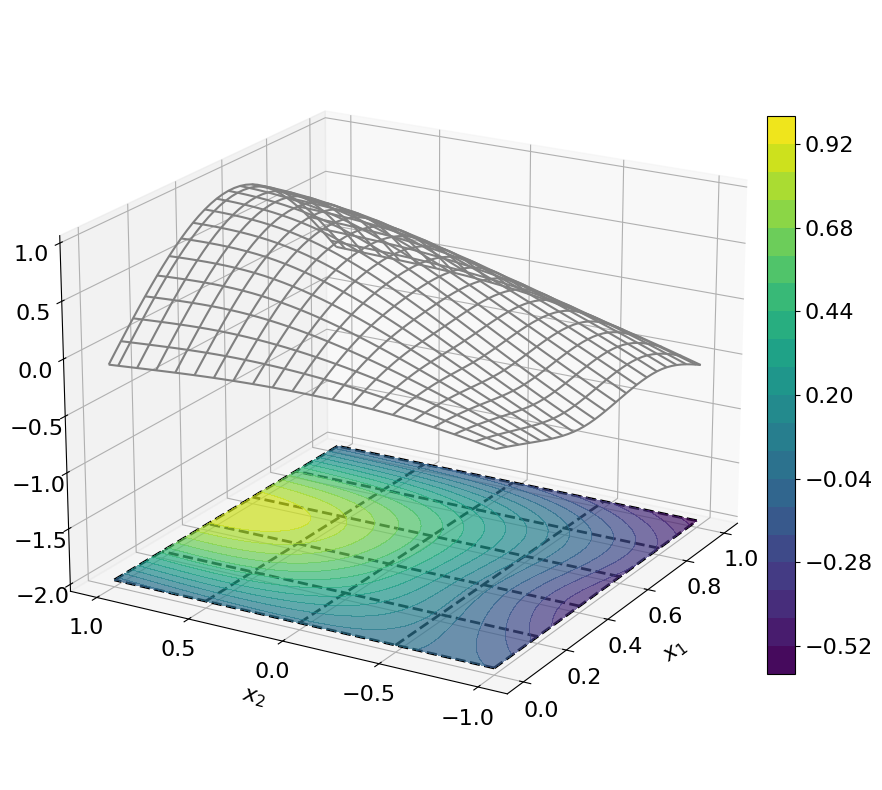

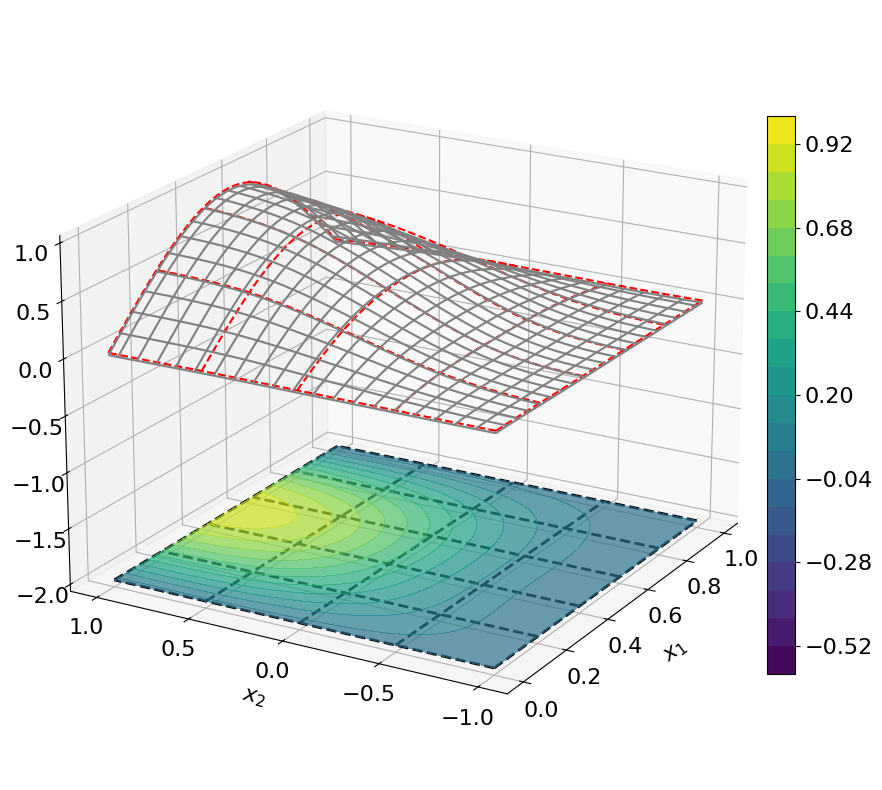

In [4]:
def plot_curve_knots(
    knot_plane: Union[int, float] = -3,
    curve_step: Union[int, float] = 0.02,
    add_error: bool = True, 
    add_constraints: bool = False,
    add_curves: bool = True, 
    figsize: Tuple[Union[int, float], Union[int, float]] = (12, 10),
) -> Axes:
    _, ax = plt.subplots(figsize=figsize,
                         subplot_kw=dict(projection="3d"))
    n = 40
    np.random.seed(2)
    x_1 = np.repeat(np.linspace(0, 1, n), n)
    x_2 = np.tile(np.linspace(-1, 1, n), n)
    y =  np.sin(np.pi * x_1) * np.exp(8 * x_2) / (1 + np.exp(8 * x_2))
    error = np.random.normal(0, 2, n*n) if add_error else 0
    int_constraints = int_constraints={"x1": {0: {"+": 0}},
                                       "x2": {0: {"+": 0}}} if add_constraints else None
        
    data = pd.DataFrame({"x1": x_1, "x2": x_2, "y_": y + error})
    cps = CPsplines(deg=(3, 3), ord_d=(2, 2), n_int=(5, 4),
                    int_constraints=int_constraints)
    cps.fit(data=data, y_col="y_")
    
    print(f"MAE = {mean_absolute_error(cps.predict(data[['x1', 'x2']]), y)}")
    print(f"MSE = {mean_squared_error(cps.predict(data[['x1', 'x2']]), y)}")
    
    Z = data["x1"].values.reshape((n, n), order="F")
    X = data["x2"].values.reshape((n, n), order="F")
    Y = cps.predict(data[["x1", "x2"]]).reshape((n, n), order="F")
    # Graph the points of the surface using a wireframe plot
    _ = ax.plot_wireframe(Z, X, Y, rstride=2, cstride=2, color="grey")
    levels = np.linspace(-0.6, 1, 21)
    surf = ax.contourf(Z, X, Y, cmap="viridis", offset=knot_plane, alpha=0.7, levels=levels)
    cbar = ax.figure.colorbar(surf, ax=ax, fraction=0.03, pad=-0.02)
    cbar.solids.set(alpha=1)
    # Plot the knot mesh and the curves in the surface along the X_1-axis
    for kn in cps.bspline_bases[0].knots[cps.bspline_bases[0].deg : -cps.bspline_bases[0].deg]:
        _ = ax.plot(
            np.repeat(kn, len(cps.bspline_bases[1].xsample)),
            cps.bspline_bases[1].xsample,
            np.repeat(knot_plane, len(cps.bspline_bases[1].xsample)),
            color="k",
            linestyle="--",
            linewidth=2.0,
            alpha=1,
        )
        if add_curves:
            _ = ax.plot(
                np.repeat(kn, len(cps.bspline_bases[1].xsample)),
                cps.bspline_bases[1].xsample,
                Y[:, np.abs(cps.bspline_bases[0].xsample - kn).argmin()] + curve_step,
                color="red",
                linestyle="--",
                alpha=1,
            )
    # Plot the knot mesh and the curves in the surface along the X_2-axis
    for kn in cps.bspline_bases[1].knots[cps.bspline_bases[1].deg : -cps.bspline_bases[1].deg]:
        _ = ax.plot(
            cps.bspline_bases[0].xsample,
            np.repeat(kn, len(cps.bspline_bases[0].xsample)),
            np.repeat(knot_plane, len(cps.bspline_bases[0].xsample)),
            color="k",
            linestyle="--",
            linewidth=2.0,
            alpha=1,
        )
        if add_curves:
            _ = ax.plot(
                cps.bspline_bases[0].xsample,
                np.repeat(kn, len(cps.bspline_bases[0].xsample)),
                Y[np.abs(cps.bspline_bases[1].xsample - kn).argmin(), :] + curve_step,
                color="red",
                linestyle="--",
                alpha=1,
            )
    return ax

ax = plot_curve_knots(knot_plane=-2, add_error=True, add_constraints=False, add_curves=False)
_ = ax.set_xlabel("$x_1$", labelpad=10)
_ = ax.set_ylabel('$x_2$', labelpad=10)
_ = ax.set_yticks([-1, -0.5, 0, 0.5, 1])
_ = ax.view_init(20, 210)
_ = ax.set_zlim(-2, 1)

if SAVEFIG:
    _ = ax.get_figure().savefig("../img/curvas_nodo_unconstrained.pdf", bbox_inches="tight")
    
ax = plot_curve_knots(knot_plane=-2, add_error=True, add_constraints=True, add_curves=True)
_ = ax.set_xlabel("$x_1$", labelpad=10)
_ = ax.set_ylabel("$x_2$", labelpad=10)
_ = ax.set_yticks([-1, -0.5, 0, 0.5, 1])
_ = ax.view_init(20, 210)
_ = ax.set_zlim(-2, 1)
        
if SAVEFIG:
    _ = ax.get_figure().savefig("../img/curvas_nodo_constrained.pdf", bbox_inches="tight")

FIGURE 2. Perspective and contour plots of surfaces defined by the function $f$ in Table 1.

(a) $f$ in Scenario 1. 
(b) $f$ in Scenario 2. 
(c) $f$ in Scenario 3. 

2024-01-24 20:42:27,700 | INFO: Data is rearranged into a grid.


[Solve the problem with smoothing parameters (1.0, 1.0): ] Elapsed time (s): 0.054796


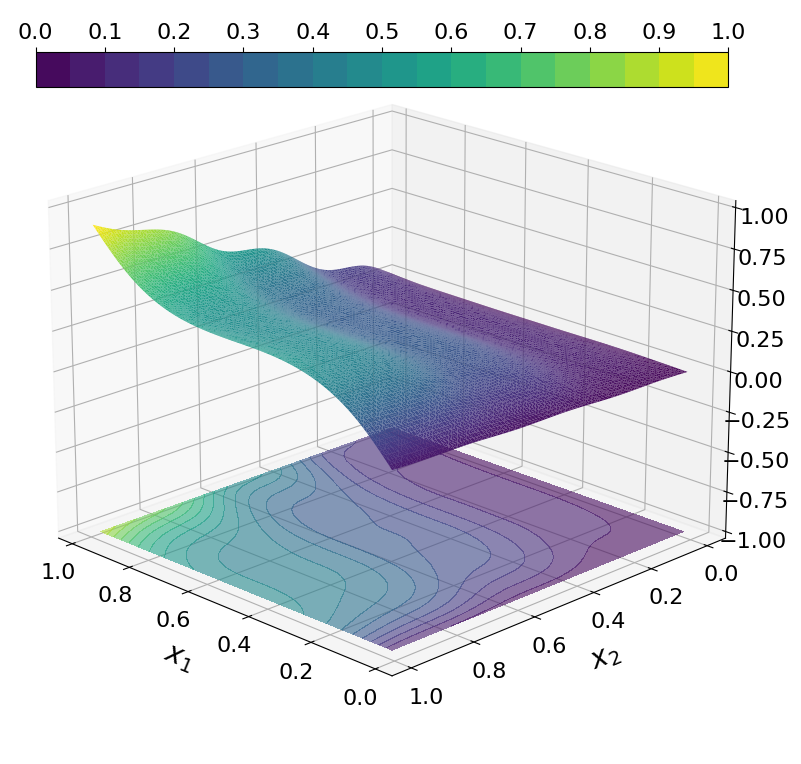

In [5]:
data = generate_data(x_1=(0, 1), x_2=(0, 1), n=50, grid=True)

cps = CPsplines(deg=(3, 3), ord_d=(2, 2), n_int=(20, 20))
cps.fit(data=data, y_col="y_")

X, Y = np.meshgrid(np.linspace(data.iloc[:, 0].min(), data.iloc[:, 0].max()),
                   np.linspace(data.iloc[:, 1].min(), data.iloc[:, 1].max()))
Z = cps.predict(pd.DataFrame({"x1": X.flatten(), "x2": Y.flatten()})).reshape((50, 50))

surface1 = SurfacesDisplay.from_estimator(cps, 
                                          orientation=(20, 135), 
                                          figsize=(12, 10), 
                                          contour_plot=False,
                                          **{"cmap": "viridis"}
                                          )
_ = surface1.ax_.set_xlabel('$x_1$', labelpad=10, fontsize=20)
_ = surface1.ax_.set_ylabel('$x_2$', labelpad=10, fontsize=20)
surf = surface1.ax_.contourf(X, Y, Z, levels=np.linspace(0, 1, 21),
                             cmap="viridis", offset=-1, alpha=0.6)
_ = surface1.ax_.set_zlim((-1, 1))
_ = surface1.figure_.delaxes(surface1.figure_.axes[1])
cbar = surface1.figure_.colorbar(surf, orientation="horizontal",
                                 location="top", pad=-0.1, fraction=0.045)
cbar.set_ticks(np.linspace(0, 1, 11))
cbar.set_ticklabels(np.round(np.linspace(0, 1, 11), 1))
cbar.solids.set(alpha=1)
if SAVEFIG:
    _ = surface1.ax_.get_figure().savefig("../img/simulated_example1.pdf", bbox_inches="tight")

2024-01-24 20:42:31,209 | INFO: Data is rearranged into a grid.


[Solve the problem with smoothing parameters (1.0, 1.0): ] Elapsed time (s): 0.078358


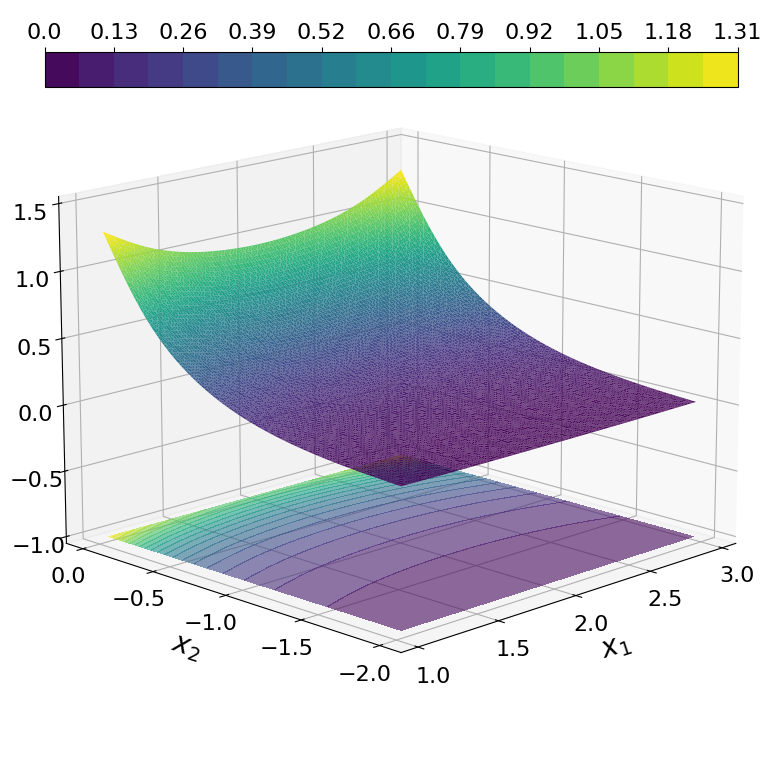

In [6]:
data = generate_data(x_1=(1, 3), x_2=(-2, 0), n=50, grid=True, scenario=2)

cps = CPsplines(deg=(3, 3), ord_d=(2, 2), n_int=(20, 20))
cps.fit(data=data, y_col="y_")

X, Y = np.meshgrid(np.linspace(data.iloc[:, 0].min(), data.iloc[:, 0].max()),
                   np.linspace(data.iloc[:, 1].min(), data.iloc[:, 1].max()))
Z = cps.predict(pd.DataFrame({"x0": X.flatten(), "y_": Y.flatten()})).reshape((50, 50))

surface1 = SurfacesDisplay.from_estimator(cps, 
                                          orientation=(15, 225), 
                                          figsize=(12, 10), 
                                          contour_plot=False,
                                          **{"cmap": "viridis"}
                                          )
_ = surface1.ax_.set_xlabel('$x_1$', labelpad=10, fontsize=20)
_ = surface1.ax_.set_xticks([1, 1.5, 2, 2.5, 3])
_ = surface1.ax_.set_ylabel('$x_2$', labelpad=10, fontsize=20)
_ = surface1.ax_.set_yticks([-2, -1.5, -1, -0.5, 0])
surf = surface1.ax_.contourf(X, Y, Z, levels=np.linspace(0, 1.31, 21),
                             cmap="viridis", offset=-1, alpha=0.6)
_ = surface1.ax_.set_zlim((-1, 1.5))
_ = surface1.figure_.delaxes(surface1.figure_.axes[1])
cbar = surface1.figure_.colorbar(surf, orientation="horizontal",
                                 location="top", pad=-0.1, fraction=0.045)
cbar.set_ticks(np.linspace(0, 1.31, 11))
cbar.set_ticklabels(np.round(np.linspace(0, 1.31, 11), 2))
cbar.solids.set(alpha=1)
if SAVEFIG:
    _ = surface1.ax_.get_figure().savefig("../img/simulated_example2.pdf", bbox_inches="tight")

2024-01-24 20:42:35,925 | INFO: Data is rearranged into a grid.


[Solve the problem with smoothing parameters (1.0, 1.0): ] Elapsed time (s): 0.045138


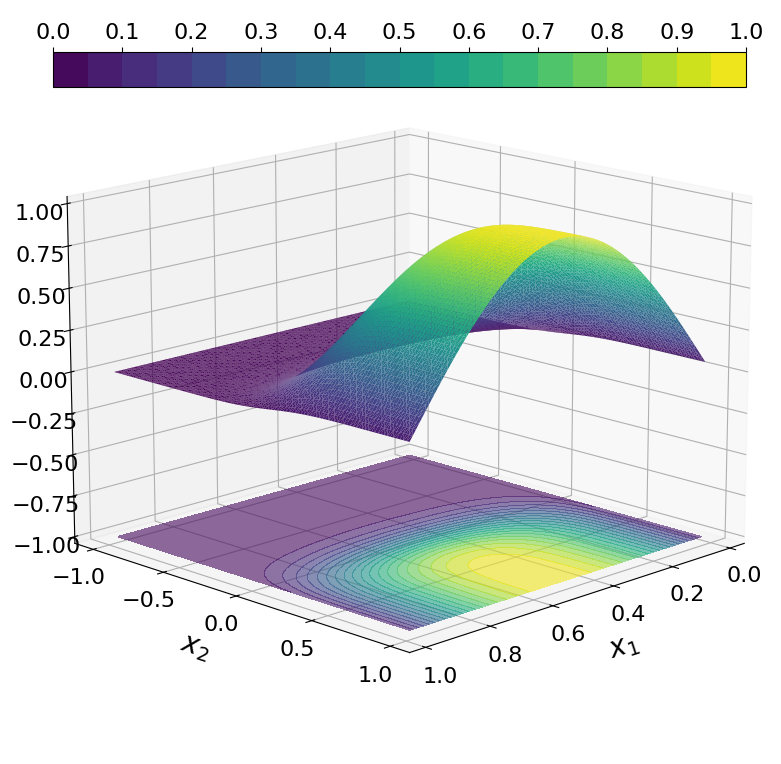

In [7]:
data = generate_data(x_1=(0, 1), x_2=(-1, 1), n=50, grid=True, scenario=3)

cps = CPsplines(deg=(3, 3), ord_d=(2, 2), n_int=(20, 20))
cps.fit(data=data, y_col="y_")

X, Y = np.meshgrid(np.linspace(data.iloc[:, 0].min(), data.iloc[:, 0].max()),
                   np.linspace(data.iloc[:, 1].min(), data.iloc[:, 1].max()))
Z = cps.predict(pd.DataFrame({"x0": X.flatten(), "y_": Y.flatten()})).reshape((50, 50))

surface1 = SurfacesDisplay.from_estimator(cps, 
                                          orientation=(15, 45), 
                                          figsize=(12, 10), 
                                          contour_plot=False,
                                          **{"cmap": "viridis"}
                                          )
_ = surface1.ax_.set_xlabel('$x_1$', labelpad=10, fontsize=20)
_ = surface1.ax_.set_ylabel('$x_2$', labelpad=10, fontsize=20)
_ = surface1.ax_.set_yticks([-1, -0.5, 0, 0.5, 1])
surf = surface1.ax_.contourf(X, Y, Z, levels=np.linspace(0, 1, 21),
                             cmap="viridis", offset=-1, alpha=0.6)
_ = surface1.ax_.set_zlim((-1, 1))
_ = surface1.figure_.delaxes(surface1.figure_.axes[1])
cbar = surface1.figure_.colorbar(surf, orientation="horizontal",
                                 location="top", pad=-0.1, fraction=0.045)
cbar.set_ticks(np.linspace(0, 1, 11))
cbar.set_ticklabels(np.round(np.linspace(0, 1, 11), 1))
cbar.solids.set(alpha=1)
if SAVEFIG:
    _ = surface1.ax_.get_figure().savefig("../img/simulated_example3.pdf", bbox_inches="tight")

FIGURE 3. Perspective and contour plots of surfaces defined by the function $f$ in Table 3.

(a) $f$ in Scenario 4. 
(b) $f$ in Scenario 5. 

2024-01-24 20:42:40,030 | INFO: Data is rearranged into a grid.


[Solve the problem with smoothing parameters (1.0, 1.0): ] Elapsed time (s): 0.014484


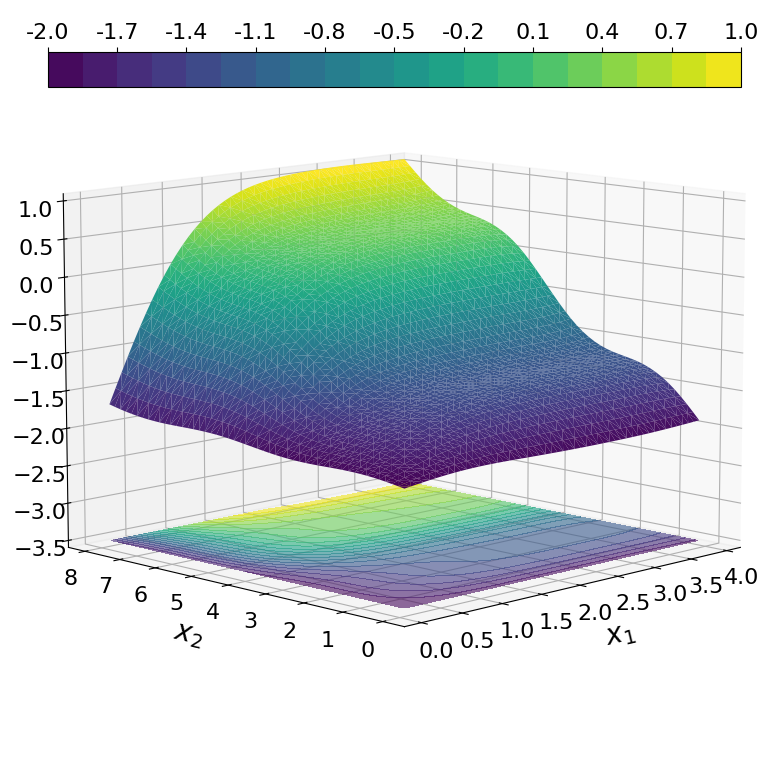

In [8]:
data = generate_data(x_1=(0, 4), x_2=(0, 8), n=50, grid=True, scenario=4)

cps = CPsplines(deg=(3, 3), ord_d=(2, 2), n_int=(10, 10))
cps.fit(data=data, y_col="y_")

X, Y = np.meshgrid(np.linspace(data.iloc[:, 0].min(), data.iloc[:, 0].max()),
                   np.linspace(data.iloc[:, 1].min(), data.iloc[:, 1].max()))
Z = cps.predict(pd.DataFrame({"x0": X.flatten(), "y_": Y.flatten()})).reshape((50, 50))

surface1 = SurfacesDisplay.from_estimator(cps, 
                                          orientation=(10, 225), 
                                          figsize=(12, 10), 
                                          contour_plot=False,
                                          **{"cmap": "viridis"}
                                          )
_ = surface1.ax_.set_xlabel('$x_1$', labelpad=10, fontsize=20)
_ = surface1.ax_.set_ylabel('$x_2$', labelpad=10, fontsize=20)
surf = surface1.ax_.contourf(X, Y, Z, levels=np.linspace(-2, 1, 21),
                             cmap="viridis", offset=-3.5, alpha=0.6)
_ = surface1.ax_.set_zlim((-3.5, 1))
_ = surface1.figure_.delaxes(surface1.figure_.axes[1])
cbar = surface1.figure_.colorbar(surf, orientation="horizontal",
                                 location="top", pad=-0.1, fraction=0.045)
cbar.set_ticks(np.linspace(-2, 1, 11))
cbar.set_ticklabels(np.round(np.linspace(-2, 1, 11), 2))
cbar.solids.set(alpha=1)
if SAVEFIG:
    _ = surface1.ax_.get_figure().savefig("../img/simulated_example4.pdf", bbox_inches="tight")

2024-01-24 20:42:41,533 | INFO: Data is rearranged into a grid.


[Solve the problem with smoothing parameters (1.0, 1.0): ] Elapsed time (s): 0.100666


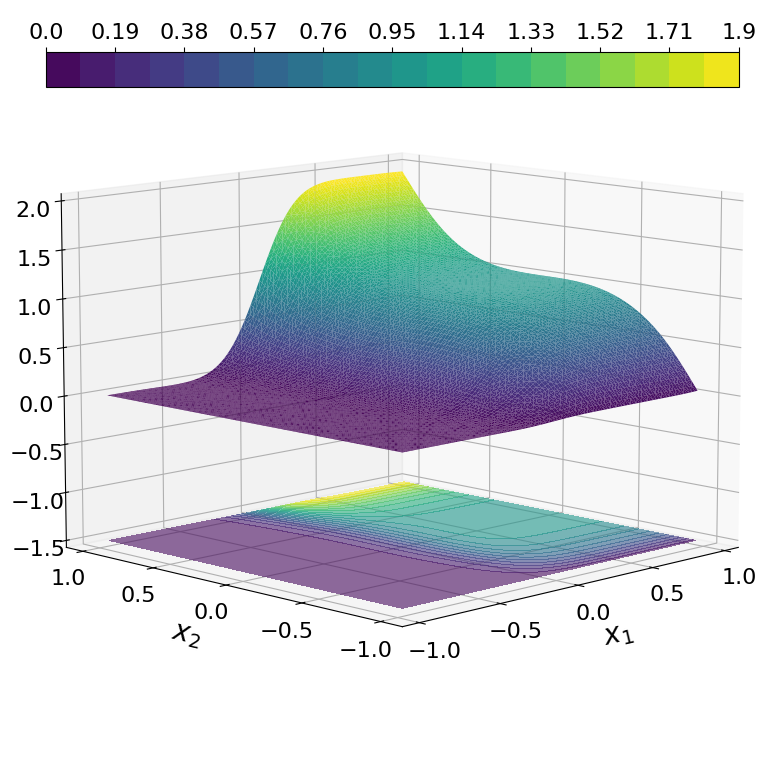

In [9]:
data = generate_data(x_1=(-1, 1), x_2=(-1, 1), n=50, grid=True, scenario=5)
data["y_"] += 0.008

cps = CPsplines(deg=(3, 3), ord_d=(2, 2), n_int=(20, 20))
cps.fit(data=data, y_col="y_")

X, Y = np.meshgrid(np.linspace(data.iloc[:, 0].min(), data.iloc[:, 0].max()),
                   np.linspace(data.iloc[:, 1].min(), data.iloc[:, 1].max()))
Z = cps.predict(pd.DataFrame({"x0": X.flatten(), "y_": Y.flatten()})).reshape((50, 50))

surface1 = SurfacesDisplay.from_estimator(cps, 
                                          orientation=(10, 225), 
                                          figsize=(12, 10), 
                                          contour_plot=False,
                                          **{"cmap": "viridis"}
                                          )
_ = surface1.ax_.set_xlabel('$x_1$', labelpad=10, fontsize=20)
_ = surface1.ax_.set_xticks([-1, -0.5, 0, 0.5, 1])
_ = surface1.ax_.set_ylabel('$x_2$', labelpad=10, fontsize=20)
_ = surface1.ax_.set_yticks([-1, -0.5, 0, 0.5, 1])

surf = surface1.ax_.contourf(X, Y, Z, levels=np.linspace(0, 1.9, 21),
                             cmap="viridis", offset=-1.5, alpha=0.6)
_ = surface1.figure_.delaxes(surface1.figure_.axes[1])
cbar = surface1.figure_.colorbar(surf, orientation="horizontal",
                                 location="top", pad=-0.1, fraction=0.045)
cbar.set_ticks(np.linspace(0, 1.9, 11))
cbar.set_ticklabels(np.round(np.linspace(0, 1.9, 11), 2))
cbar.solids.set(alpha=1)
_ = surface1.ax_.set_zlim((-1.5, 2))
if SAVEFIG:
    _ = surface1.ax_.get_figure().savefig("../img/simulated_example5.pdf", bbox_inches="tight")

FIGURE 4. Contour plots of the surfaces obtained in one of the folds for the
$\texttt{hschool}$ the data set by $\text{\texttt{SCPANOVA}}_{\text{UI}}$,
$\text{\texttt{SCPANOVA}}_{\text{CI}}$, $\texttt{scam}$ and $\texttt{cgam}$.

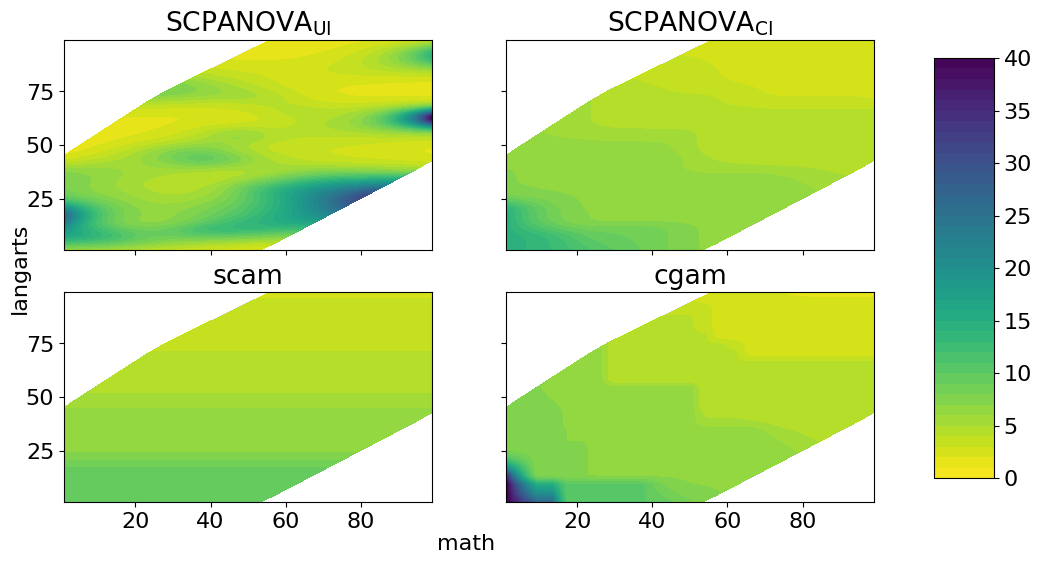

In [10]:
hschool_fold = pd.read_csv("../data/hschool_fold_pred.csv")
cols_pred = ["Unconstrained", "cpsplines", "scam", "cgam"]
map_col = {"Unconstrained": "$\mathrm{SCPANOVA}_{\mathrm{UI}}$",
           "cpsplines": "$\mathrm{SCPANOVA}_{\mathrm{CI}}$", "scam": "scam", "cgam": "cgam"} 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True, sharey=True)
for ax, col in zip(axes.flat, cols_pred):
    im = ax.tricontourf(*hschool_fold[["math", "langarts", col]].to_numpy().T,
                        cmap="viridis_r",
                        levels=np.linspace(0, 40, 41))
    _ = ax.set_title(map_col[col])

_ = fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
_ = fig.colorbar(im, cax=cbar_ax)
_ = fig.text(0.46, 0.03, 'math', ha='center')
_ = fig.text(0.08, 0.5, 'langarts', va='center', rotation='vertical')
if SAVEFIG:
    _ = fig.savefig("../img/hschool.pdf", bbox_inches="tight")

TABLE 2. Mean ($\mu_{\boldsymbol{\cdot}}$) and standard deviation
($\sigma_{\boldsymbol{\cdot}}$) over $100$ replicates of the MAE and MSE, between
the theoretical function $f$ and the estimated values, and computational times in
seconds, for each of the Scenarios $1-3$ in Table $1$ and data structure (gridded and
scattered).

In [11]:
pd.read_parquet("../data/table2.parquet")

Gridded                                         Scattered  \
             SCPANOVA_CI SCPANOVA_UI         cgam         scam SCPANOVA_CI   
1 MAE   mean    0.035871    0.043392     0.043378     0.035649    0.034940   
        std     0.005502    0.005972     0.005651     0.005931    0.005331   
  MSE   mean    0.002212    0.003180     0.003352     0.002203    0.002071   
        std     0.000616    0.000826     0.000859     0.000723    0.000625   
  Times mean   15.017557   10.594910   498.581169   132.320234   44.953697   
        std     8.337969    6.960762   398.340158   113.166797    8.345731   
2 MAE   mean    0.027303    0.037234     0.027175     0.041636    0.026643   
        std     0.005153    0.005809     0.005367     0.006613    0.004650   
  MSE   mean    0.001339    0.002328     0.001392     0.003254    0.001286   
        std     0.000453    0.000657     0.000519     0.000804    0.000380   
  Times mean   24.064984   18.944955  1059.011158   514.236116   99.489145   
        std     6.566836    4.296864   563.447392   617.775176   55.410895   
3 MAE   mean    0.024759    0.039424          NaN     0.041936    0.025392   
        std     0.004958    0.005641          NaN     0.012834    0.005551   
  MSE   mean    0.001231    0.002559          NaN     0.003074    0.001242   
        std     0.000411    0.000688          NaN     0.002205    0.000445   
  Times mean   13.448955    9.182710          NaN  1170.892815  100.360307   
        std     3.805101    2.003584          NaN   722.676033   75.020221   

                                                   
             SCPANOVA_UI         cgam        scam  
1 MAE   mean    0.042976     0.043170    0.035876  
        std     0.006027     0.007071    0.008872  
  MSE   mean    0.003029     0.003335    0.002271  
        std     0.000823     0.001164    0.001036  
  Times mean   41.004637  3814.759865  199.561237  
        std     8.409724  4343.274052  325.701865  
2 MAE   mean    0.036804     0.026766    0.042456  
        std     0.005488     0.004528    0.004792  
  MSE   mean    0.002285     0.001325    0.003433  
        std     0.000703     0.000393    0.000566  
  Times mean   89.720228   460.387765  348.033940  
        std    36.334303   327.072221  377.921888  
3 MAE   mean    0.039282          NaN    0.045035  
        std     0.005356          NaN    0.012024  
  MSE   mean    0.002519          NaN    0.003463  
        std     0.000720          NaN    0.002246  
  Times mean   80.932726          NaN  766.144982  
        std    76.476360          NaN  439.861211

TABLE 4. Mean ($\mu_{\boldsymbol{\cdot}}$) and standard deviation
($\sigma_{\boldsymbol{\cdot}}$) over $100$ replicates of the MAE and MSE, between
the theoretical function $f$ and the estimated values, and computational times in
seconds, for each of the Scenarios $4$ and $5$ in Table $3$ and data structure (gridded
and scattered).

In [12]:
pd.read_parquet("../data/table4.parquet")

SCPANOVA_UI         cgam  SCPANOVA_CI         scam
4 MAE   mean     0.112723     0.145382     0.099562     0.109367
        std      0.019011     0.025402     0.018474     0.027501
  MSE   mean     0.023202     0.070492     0.018196     0.030045
        std      0.008478     0.064537     0.007573     0.022026
  Times mean    44.415140  1495.744893    50.899710  1595.231408
        std     14.394547   609.308614    20.901963   652.709553
5 MAE   mean     0.130557     0.144069     0.117638     0.119449
        std      0.021393     0.029318     0.020617     0.024592
  MSE   mean     0.028864     0.045584     0.024277     0.027975
        std      0.009063     0.022969     0.008272     0.012219
  Times mean    45.611508  1185.724968    74.236772  1184.588350
        std     15.992293   595.438374    31.164346   649.863070

TABLE 6. Mean ($\mu_{\boldsymbol{\cdot}}$) and standard deviation
($\sigma_{\boldsymbol{\cdot}}$) over $100$ replicates of the MAE and MSE, between
the theoretical function $f$ and the estimated values, and computational times in
seconds, for each of the Scenarios $6-9$ in Table $5$ and data structure (gridded and
scattered).

In [13]:
pd.read_parquet("../data/table6.parquet")

AAFS  SCPANOVA_ANOVA       C2NLS       DEA  SCPANOVA_CI
6 MAE   mean   0.088995        0.053823    0.075726  0.073199     0.045495
        std    0.010462        0.017242    0.036452  0.010593     0.010206
  MSE   mean   0.018816        0.005251    0.009433  0.012570     0.003540
        std    0.005004        0.004142    0.008443  0.004359     0.002116
  Times mean  10.294137        1.692481  659.254845  0.215787     1.524146
        std    4.350404        1.584919   95.571344  0.104137     0.883552
7 MAE   mean   0.033386        0.050377    0.065917  0.067968     0.038804
        std    0.005744        0.016291    0.032485  0.009896     0.009230
  MSE   mean   0.002268        0.004666    0.007359  0.011085     0.002640
        std    0.000859        0.003671    0.006270  0.004072     0.001780
  Times mean  11.635310        1.788020  728.530040  0.219874     1.532082
        std    5.677696        1.896966  110.765195  0.108411     0.871832
8 MAE   mean   0.306187        0.082142    0.094886  0.085906     0.072970
        std    0.042517        0.017044    0.048397  0.010789     0.010470
  MSE   mean   0.266254        0.011128    0.014943  0.010868     0.008444
        std    0.070520        0.005310    0.015462  0.002684     0.002422
  Times mean  11.086374        1.499950  519.645208  0.211241     1.490466
        std    3.781606        1.256250   67.393226  0.104723     0.875297
9 MAE   mean   0.345737        0.073525    0.126349  0.088742     0.064147
        std    0.045471        0.016051    0.063547  0.009446     0.009615
  MSE   mean   0.263321        0.008740    0.024145  0.012817     0.006078
        std    0.055698        0.004491    0.026237  0.002874     0.001945
  Times mean  10.316719        1.616633  563.844332  0.219884     1.391306
        std    3.126367        1.426664   74.807486  0.111246     0.765398

TABLE 7. Mean ($\mu_{\boldsymbol{\cdot}}$) and standard deviation
($\sigma_{\boldsymbol{\cdot}}$) over the $10$ folds of the MAE and MSE, between the
observed and the estimated values in the $\texttt{hschool}$ data set, and the
computational times in seconds.

In [14]:
pd.read_parquet("../data/table7.parquet")

SCPANOVA_UI        cgam  SCPANOVA_CI       scam
MAE   mean     4.986351    5.319432     4.928820   4.974191
      std      1.192556    1.046866     1.137613   1.122376
MSE   mean    49.753875   54.831331    47.241403  48.094405
      std     29.846443   30.797725    29.705518  30.803617
Times mean    19.884192  804.937968    24.722640  42.617252
      std      9.774750   16.648340     9.394593  36.552558

TABLE 8. Mean ($\mu_{\boldsymbol{\cdot}}$) and standard deviation
($\sigma_{\boldsymbol{\cdot}}$) over the $10$ folds of the accuracy (ACC) and the
$F_1$-score between the observed and the predicted outcome in the $\texttt{pima}$ data
set, and the computational times. 

In [15]:
pd.read_parquet("../data/table8.parquet")

ANOVA                    Additive              \
              SCPANOVA_ANOVA SCPANOVA_CANOVA SCPANOVA_UA SCPANOVA_CA   
Times    mean     108.850681      119.360977    0.633151    0.842367   
         std       58.102454       59.298009    0.051800    0.028774   
accuracy mean       0.681684        0.683000    0.683000    0.685649   
         std        0.061121        0.064140    0.060692    0.056961   
f1-score mean       0.437019        0.443167    0.437979    0.443309   
         std        0.072074        0.082866    0.071984    0.077076   

                        Interaction                         
                   scam SCPANOVA_UI SCPANOVA_CI       scam  
Times    mean  1.044024   30.249687   31.256259  34.947173  
         std   1.295595   13.838074   12.887960  48.951163  
accuracy mean  0.688281    0.687561    0.689579   0.680684  
         std   0.052728    0.058547    0.057892   0.056202  
f1-score mean  0.444825    0.415519    0.422999   0.428616  
         std   0.069704    0.070679    0.071156   0.060295

TABLE D.9: Mean ($\mu_{\boldsymbol{\cdot}}$) and standard deviation
($\sigma_{\boldsymbol{\cdot}}$) over $100$ replicates of the MAE and MSE, between the
theoretical function $f$ in Scenario $1$ and the estimated values, and computational
times in seconds, for $\sigma\in\{0.05, 0.10, 0.25\}$ and data structure (gridded
and scattered).

In [16]:
pd.read_parquet("../data/tableD9.parquet")

Gridded                                       Scattered  \
                SCPANOVA_UI        scam SCPANOVA_CI        cgam SCPANOVA_UI   
0.05 MAE   mean    0.009077    0.006991    0.007213    0.007223    0.009300   
           std     0.000589    0.003194    0.000599    0.000665    0.000619   
     MSE   mean    0.000137    0.000103    0.000092    0.000091    0.000139   
           std     0.000016    0.000166    0.000013    0.000015    0.000018   
     Times mean    1.936960  398.587685    6.278571  688.648056    6.565400   
           std     0.604622  268.913654    0.971714  208.391759    1.596526   
0.10 MAE   mean    0.013967    0.012168    0.011883    0.012458    0.014379   
           std     0.001214    0.002561    0.001116    0.001185    0.001285   
     MSE   mean    0.000319    0.000250    0.000233    0.000257    0.000336   
           std     0.000049    0.000089    0.000037    0.000045    0.000058   
     Times mean    6.231789  528.575171   10.817561  356.608602   20.502314   
           std     0.871235  304.702853    1.156345   75.678972    3.014133   
0.25 MAE   mean    0.026939    0.024170    0.022757    0.025956    0.027790   
           std     0.002866    0.005240    0.002678    0.003306    0.003177   
     MSE   mean    0.001213    0.001023    0.000874    0.001166    0.001269   
           std     0.000243    0.000552    0.000188    0.000302    0.000287   
     Times mean    9.076987  325.635800   13.383947  711.601220   33.381228   
           std     2.812290  228.315517    3.022700  884.236521    5.247409   

                                                      
                       scam SCPANOVA_CI         cgam  
0.05 MAE   mean    0.007019    0.007522     0.007697  
           std     0.002049    0.000657     0.000776  
     MSE   mean    0.000090    0.000095     0.000099  
           std     0.000064    0.000016     0.000020  
     Times mean  329.987163   10.304425  2741.248554  
           std   168.204132    1.950479   895.005573  
0.10 MAE   mean    0.013437    0.011937     0.012657  
           std     0.002934    0.001294     0.001532  
     MSE   mean    0.000304    0.000239     0.000272  
           std     0.000114    0.000047     0.000065  
     Times mean  375.342444   24.372095  2821.501665  
           std   316.605900    3.174781   626.715801  
0.25 MAE   mean    0.023529    0.023046     0.025654  
           std     0.004603    0.002564     0.003241  
     MSE   mean    0.000948    0.000888     0.001123  
           std     0.000421    0.000193     0.000293  
     Times mean  364.397112   37.346401  3250.334311  
           std   422.965643    5.377894   680.594866